In [459]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import pickle


def lorenz63(state, t, u, sigma=10.0, rho=28.0, beta=8.0/3.0):
    x, y, z = state
    dx_dt = sigma * (y - x) 
    dy_dt = x * (rho - z) - y + u
    dz_dt = x * y - beta * z
    return np.array([dx_dt, dy_dt, dz_dt])

def transition_model(y, t, h, u, n, func = lorenz63, sigma=10.0, rho=28.0, beta=8.0/3.0):
    
    k1 = func(y, t, u, sigma, rho, beta)
    k2 = func(y + h/2 * k1, t + h/2, u, sigma, rho, beta) 
    k3 = func(y + h/2 * k2, t + h/2, u, sigma, rho, beta)
    k4 = func(y + h * k3, t + h, u, sigma, rho, beta)

    states = y + h/6 * (k1 + 2*k2 + 2*k3 + k4)
    return states

def measurement_model(state, v):
    H = np.array([
        [0, 1, 0],
    ])
    return H @ (state).T + v
# 初始状态和参数

def cal_kernel_mat(data1, data2, sigma) -> np.ndarray:
    dists = cdist(data1, data2, 'sqeuclidean')
    dists = dists / sigma
    return np.exp(-dists)

def quadratic_kernel(x, y, c=1):
    return (np.dot(x, y) + c) ** 2

def quadratic_kernel_matrix(X, Y, c=1):
    n_samples_X = X.shape[0]
    n_samples_Y = Y.shape[0]
    K = np.zeros((n_samples_X, n_samples_Y))
    
    for i in range(n_samples_X):
        for j in range(n_samples_Y):
            K[i, j] = quadratic_kernel(X[i], Y[j], c)
    return K

In [460]:
def generate_true_states(init_state, t, h, N, func = lorenz63, sigma=10.0, rho=28.0, beta=8.0/3.0):
    true_states = np.zeros((N, 3))
    true_states[0,:] = init_state
    for n in range(1, N):
        u_n_1 = np.random.normal(0, (0))
        true_states[n] = transition_model(true_states[n-1], t, h, u_n_1, n, func = lorenz63, sigma=10.0, rho=28.0, beta=8.0/3.0)
    return true_states


In [461]:
def particle_filter(P_init, M, N, u_n,  v_n, sigma=10.0, rho=28.0, beta=8.0/3.0):
    particles = np.random.multivariate_normal(P_init['mean'], P_init['cov'], M)
    # print("particles:", particles.shape)
    weights = np.ones(M) / M
    estimates = []
#     MM = 2000
    for n in range(N):
        u_n = np.random.normal(0, (sigma_u), M)
        particles = np.array([transition_model(particles[i,:], t, h, u_n[i], n, func = lorenz63, sigma=10.0, rho=28.0, beta=8.0/3.0) for i in range(M)])
        # particles = transition_model(particles, t, h, u_n, n)
        # print("particles:", particles.shape)
        v_n = np.random.normal(0, (sigma_v), M)
        y_n = measurement_model(particles, v_n).reshape(M)
        true_measurement = measurement_model(true_states[n,:], 0)
        # aaa= 
        likelihoods = np.exp(-0.5 * ((y_n - true_measurement)**2) / sigma_v)
        weights *= likelihoods
        weights /= np.sum(weights)
#      
        resample_indices = np.random.choice(np.arange(M), size=M, p=weights)
        particles = particles[resample_indices]
        weights = weights[resample_indices]
        weights /= np.sum(weights)
        
        estimate = np.average(particles, axis=0, weights=weights)
       
        estimates.append(estimate)
        
        
    return estimates

In [462]:
def adaptive_kernel_byes_filter(P_init, M, N, u_n,  v_n, func = lorenz63, sigma=10.0, rho=28.0, beta=8.0/3.0, lambda_reg=1e-5, k=1e-5, reg2=1e-5):
    x = np.random.multivariate_normal(P_init['mean'], P_init['cov'], M)
    x_tilde_n = x
    w0 = np.ones(M) / M

    estimates = []
    for n in range(0, N):
        # Prediction in data space
        # u_n = np.random.normal(0, (sigma_u), M)
        x_n = np.array([transition_model(x_tilde_n[i], t, h, u_n[i], n) for i in range(M)])
        if x_n.ndim == 1:
            x_n = x_n[:, np.newaxis]
        
        
        GX = quadratic_kernel_matrix(x_n, x_n, c=1)
        w_n_minus = w0.reshape(M)
        
        # Update in data space
        # v_n = np.random.normal(0, (sigma_v), M)
        y_n = np.array([measurement_model(x_n[i], v_n[i]) for i in range(M)])
        if y_n.ndim == 1:
            y_n = y_n[:, np.newaxis]
        y_n_measurement = measurement_model(true_states[n], 0)
        
        GY = quadratic_kernel_matrix(y_n, y_n, c=1)
        G_yn = quadratic_kernel_matrix(y_n, y_n_measurement.reshape(1, -1), c=1)
 
        # Update weights w_n using Kernel Bayes Rule
        
        K = GX + k * np.eye(M) 
        gamma1 = np.linalg.solve(K, w_n_minus @ GX)
        gamma = gamma1 
        D = np.diag(np.maximum(0.0, gamma))
        
        w_n = np.linalg.solve(D @ GY +  reg2 * np.eye(M), D @ G_yn)
        
        μ_xn = x_n.T @ w_n
        mean_xn = μ_xn
        
        mean_diff = x_n - μ_xn.T  # 将 `μ_xn` 转置以匹配 `x_n` 的形状
        cov_diag = np.var(mean_diff, axis=0)  # 每个维度上的方差

        # 将方差转化为协方差对角矩阵
        cov_matrix = np.diag(cov_diag)

        # 生成多元正态分布样本
        x_tilde_n = np.random.multivariate_normal(mean_xn.squeeze(), cov_matrix, M)

        Γn = np.linalg.inv(quadratic_kernel_matrix(x_tilde_n, x_tilde_n, c=1) +  lambda_reg * np.eye(M)) @ quadratic_kernel_matrix(x_tilde_n, x_n, c=1)
        w0 = Γn @ w_n
        estimates.append(x_tilde_n.T @ w0)
        
        # akbf_estimates_flat = np.array([estimate.squeeze() for estimate in akbf_estimates])
    
    return w_n, estimates


In [463]:
# 自适应核卡尔曼滤波器
def adaptive_kernel_kalman_filter(P_init, M, N, u_n,  v_n, sigma_v, func = lorenz63, sigma=10.0, rho=28.0, beta=8/3, lambda_reg=1e-5, k=1e-5, reg2=1e-5):
    x = np.random.multivariate_normal(P_init['mean'], P_init['cov'], M)
    x_tilde_n = x
    sigma1 = np.median(cdist(x, x) ** 2) * 2
    w0 = np.ones(M) / M
    S_n = np.eye(M) * sigma_v
    V_n = np.eye(S_n.shape[0]) * sigma_v
    Γ0 = np.eye(M)  #(20, 20)
    
    estimates = []

    for n in range(0, N):
        
        # Prediction in data space
        # u_n = np.random.normal(0, (sigma_u), M)
        x_n = np.array([transition_model(x_tilde_n[i], t, h, u_n[i], n) for i in range(M)])
        if x_n.ndim == 1:
            x_n = x_n[:, np.newaxis]
        # Prediction in kernel feature space
        w_n_minus = w0       
        S_n_minus = S_n + V_n
        
        # Update in data space
        # v_n = np.random.normal(0, (sigma_v), M) # 
        y_n = np.array([measurement_model(x_n[i], v_n[i]) for i in range(M)])
        y_n_measurement = measurement_model(true_states[n], 0)

        # Update in kernel feature space
        Gyy = quadratic_kernel_matrix(y_n, y_n, c=1)
        G_yn = quadratic_kernel_matrix(y_n, y_n_measurement.reshape(1, -1), c=1) #Υn @ φ_y_n.T
        

        # Update weights w_n
        Qn = S_n_minus @ np.linalg.inv(Gyy @ S_n_minus + k * np.eye(Gyy.shape[0]))
        w_n = w_n_minus + Qn @ (G_yn.flatten() - Gyy @ w_n_minus)
        S_n = S_n_minus - Qn @ Gyy @ S_n_minus
        
        μ_xn = x_n.T @ w_n
        
        mean_xn = μ_xn
        mean_diff = x_n - μ_xn.T  # 将 `μ_xn` 转置以匹配 `x_n` 的形状
        cov_diag = np.var(mean_diff, axis=0)  # 每个维度上的方差

        # 将方差转化为协方差对角矩阵
        cov_matrix = np.diag(cov_diag)

        # 生成多元正态分布样本
        x_tilde_n = np.random.multivariate_normal(mean_xn.squeeze(), cov_matrix, M)

        GX_tilde = quadratic_kernel_matrix(x_tilde_n, x_tilde_n)
        V_n_1 = (np.linalg.inv(GX_tilde +  lambda_reg * np.eye(M))@ GX_tilde - np.eye(M))
        V_n = (1/M) * (V_n_1 @ V_n_1.T)
        
        GX_tilde_2=quadratic_kernel_matrix(x_tilde_n, x_n)
        Γn = np.linalg.inv( GX_tilde +  lambda_reg * np.eye(M)) @ GX_tilde_2
        w0 = Γn @ w_n
        S_n = Γn @ S_n @ Γn.T  
        aa = x_tilde_n.T @ w0
        estimates.append(x_tilde_n.T @ w0)

    return w_n, S_n, estimates

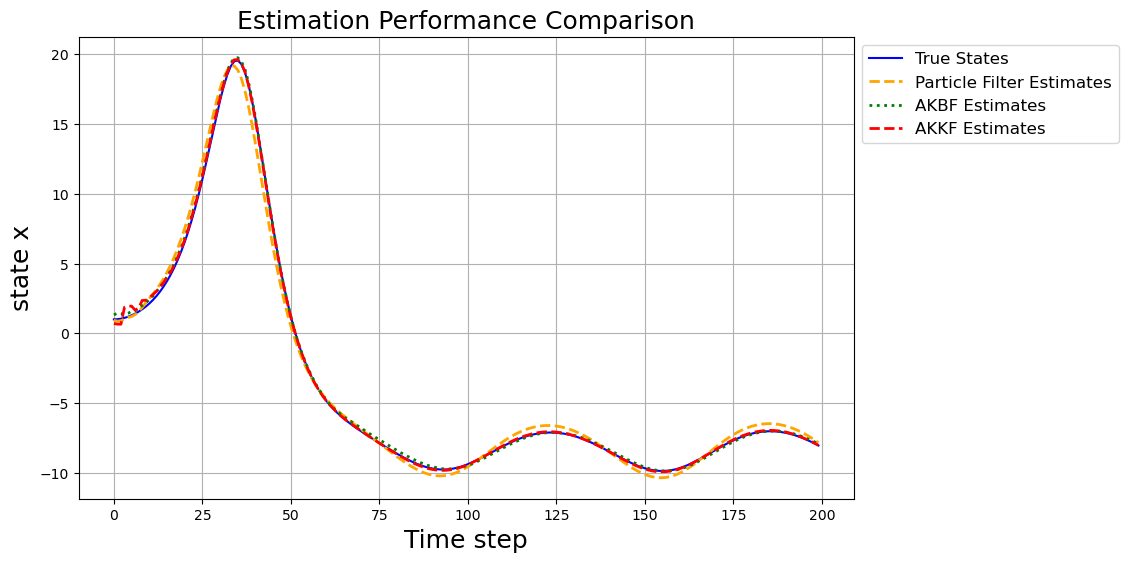

In [99]:
import numpy as np
# 定义参数
init_state = np.array([1.0, 1.0, 1.0])
t = 0
h = 0.01  # 步长
# u=0

P_init = {
    'mean': [1.0, 1.0, 1.0],  # 三维初始均值
    'cov': 1*np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ])  # 三维协方差矩阵
}

# t_span = (0, 25)
M = 100
N = 200
sigma_u = 0
sigma_v = 1
u_n = np.random.normal(0, (sigma_u), M)
v_n = np.random.normal(0, (sigma_v), M)


true_states = generate_true_states(init_state, t, h, N, func = lorenz63, sigma=10.0, rho=28.0, beta=8.0/3.0)
# 运行三个滤波器
pf_estimates = particle_filter(P_init, M, N, u_n,  v_n)
_, _, akkf_estimates = adaptive_kernel_kalman_filter(P_init, M, N, u_n,  v_n, sigma_v)
_,  akbf_estimates = adaptive_kernel_byes_filter(P_init, M, N, u_n,  v_n)
pf_estimates = np.array(pf_estimates)  # 将 pf_estimates 转换为 NumPy 数组
akbf_estimates = np.array(akbf_estimates)  # 将 akbf_estimates 转换为 NumPy 数组
akkf_estimates = np.array(akkf_estimates)


# 绘图
fig=plt.figure(figsize=(10, 6))
plt.plot(true_states[:,0], label='True States', linestyle='-', color='blue')

# 现在可以使用二维索引访问数组的元素
plt.plot(pf_estimates[:, 0], label='Particle Filter Estimates', linestyle='--', color='orange', linewidth=2)
plt.plot(akbf_estimates[:, 0],label='AKBF Estimates', linestyle=':', color='green', linewidth=2)
plt.plot(akkf_estimates[:, 0], label='AKKF Estimates', linestyle='--', color='red', linewidth=2)

plt.xlabel('Time step', fontsize=18)
plt.ylabel('state x', fontsize=18)
plt.title('Estimation Performance Comparison', fontsize=18)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 12})
plt.grid()
plt.show()

with open('Q-lorenz63-M30-sigma1.pkl', 'wb') as f:
    pickle.dump(fig, f)


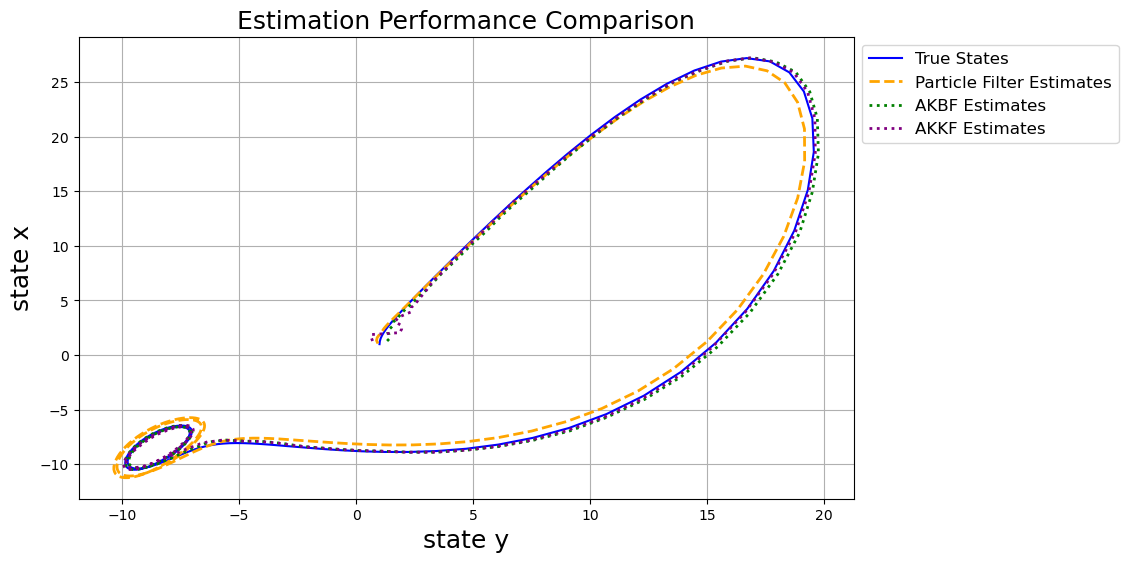

In [100]:
# 绘图
plt.figure(figsize=(10, 6))
plt.plot(true_states[:,0],true_states[:,1], label='True States', linestyle='-', color='blue')

# 现在可以使用二维索引访问数组的元素
plt.plot(pf_estimates[:, 0], pf_estimates[:, 1], label='Particle Filter Estimates', linestyle='--', color='orange', linewidth=2)
plt.plot(akbf_estimates[:, 0], akbf_estimates[:, 1],label='AKBF Estimates', linestyle=':', color='green', linewidth=2)
plt.plot(akkf_estimates[:, 0], akbf_estimates[:, 1],label='AKKF Estimates', linestyle=':', color='purple', linewidth=2)

plt.xlabel('state y', fontsize=18)
plt.ylabel('state x', fontsize=18)
plt.title('Estimation Performance Comparison', fontsize=18)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 12})
plt.grid()
plt.show()



In [ ]:
# 画出 关于 粒子个数与MSE 的关系

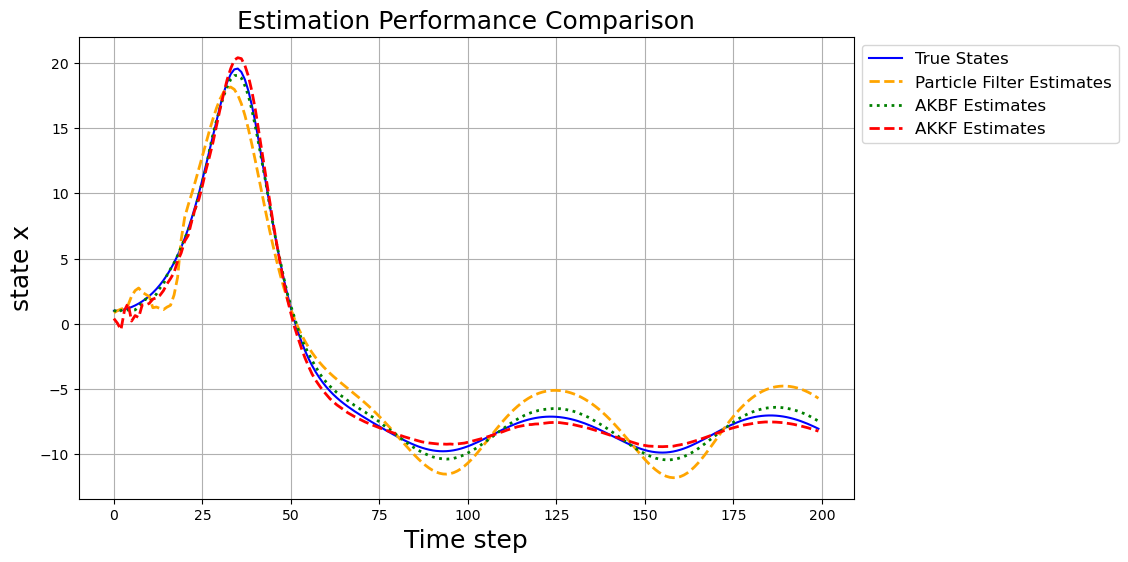

In [103]:
import numpy as np
# 定义参数
init_state = np.array([1.0, 1.0, 1.0])
t = 0
h = 0.01  # 步长
# u=0

P_init = {
    'mean': [1.0, 1.0, 1.0],  # 三维初始均值
    'cov': 4*np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ])  # 三维协方差矩阵
}

# t_span = (0, 25)
M = 100
N = 200
sigma_u = 0
sigma_v = 4
u_n = np.random.normal(0, (sigma_u), M)
v_n = np.random.normal(0, (sigma_v), M)


true_states = generate_true_states(init_state, t, h, N, func = lorenz63, sigma=10.0, rho=28.0, beta=8.0/3.0)
# 运行三个滤波器
pf_estimates = particle_filter(P_init, M, N, u_n,  v_n)
_, _, akkf_estimates = adaptive_kernel_kalman_filter(P_init, M, N, u_n,  v_n, sigma_v)
_,  akbf_estimates = adaptive_kernel_byes_filter(P_init, M, N, u_n,  v_n)
pf_estimates = np.array(pf_estimates)  # 将 pf_estimates 转换为 NumPy 数组
akbf_estimates = np.array(akbf_estimates)  # 将 akbf_estimates 转换为 NumPy 数组
akkf_estimates = np.array(akkf_estimates)


# 绘图
fig=plt.figure(figsize=(10, 6))
plt.plot(true_states[:,0], label='True States', linestyle='-', color='blue')

# 现在可以使用二维索引访问数组的元素
plt.plot(pf_estimates[:, 0], label='Particle Filter Estimates', linestyle='--', color='orange', linewidth=2)
plt.plot(akbf_estimates[:, 0],label='AKBF Estimates', linestyle=':', color='green', linewidth=2)
plt.plot(akkf_estimates[:, 0], label='AKKF Estimates', linestyle='--', color='red', linewidth=2)

plt.xlabel('Time step', fontsize=18)
plt.ylabel('state x', fontsize=18)
plt.title('Estimation Performance Comparison', fontsize=18)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 12})
plt.grid()
plt.show()

with open('Q-lorenz63-M30-sigma1.pkl', 'wb') as f:
    pickle.dump(fig, f)

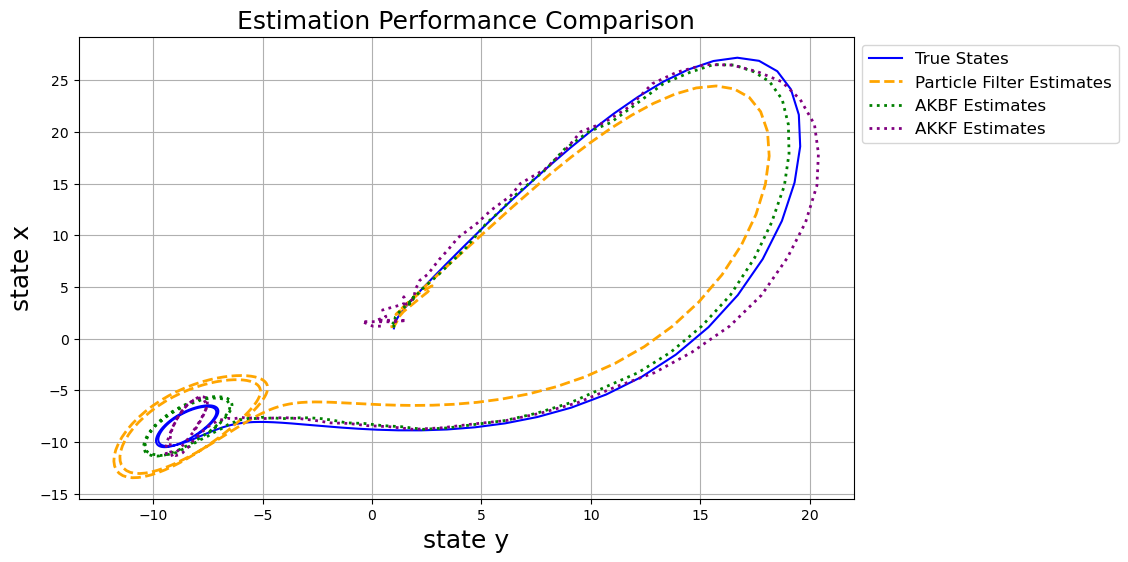

In [104]:
# 绘图
plt.figure(figsize=(10, 6))
plt.plot(true_states[:,0],true_states[:,1], label='True States', linestyle='-', color='blue')

# 现在可以使用二维索引访问数组的元素
plt.plot(pf_estimates[:, 0], pf_estimates[:, 1], label='Particle Filter Estimates', linestyle='--', color='orange', linewidth=2)
plt.plot(akbf_estimates[:, 0], akbf_estimates[:, 1],label='AKBF Estimates', linestyle=':', color='green', linewidth=2)
plt.plot(akkf_estimates[:, 0], akbf_estimates[:, 1],label='AKKF Estimates', linestyle=':', color='purple', linewidth=2)

plt.xlabel('state y', fontsize=18)
plt.ylabel('state x', fontsize=18)
plt.title('Estimation Performance Comparison', fontsize=18)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 12})
plt.grid()
plt.show()

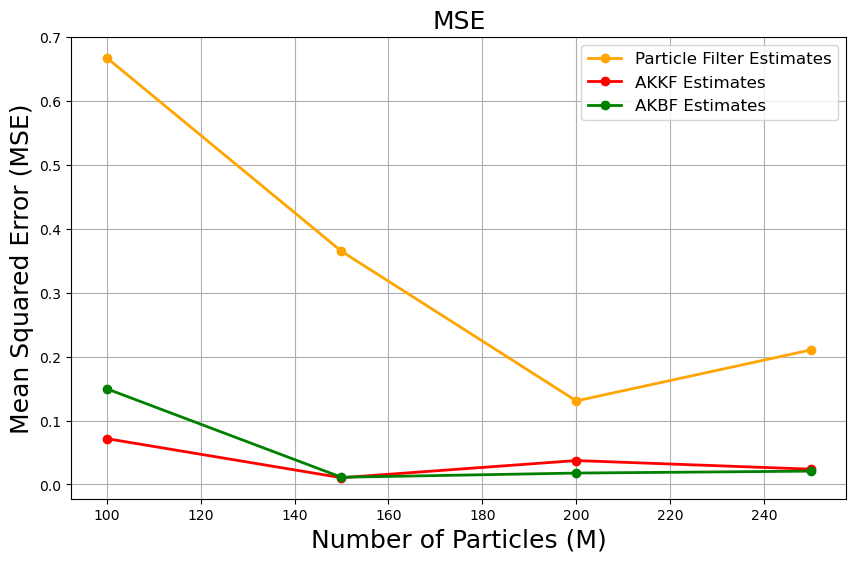

In [229]:
import numpy as np
import matplotlib.pyplot as plt

init_state = np.array([1.0, 1.0, 1.0])
t = 0
h = 0.01  # 步长
# u=0

P_init = {
    'mean': [1.0, 1.0, 1.0],  # 三维初始均值
    'cov': 1 * np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ])  # 三维协方差矩阵
}

# t_span = (0, 25)
N = 100
sigma_u = 0
sigma_v = 1


# 定义粒子数量列表
M_values = [100, 150, 200, 250]

# 生成真实状态
true_states = generate_true_states(init_state, t, h, N, func = lorenz63, sigma=10.0, rho=28.0, beta=8.0/3.0)
# 存储每个M对应的均方误差
pf_mse_list = []
akbf_mse_list = []
akkf_mse_list = []

# 运行滤波器并计算MSE
for M in M_values:
    u_n = np.random.normal(0, (sigma_u), M)
    v_n = np.random.normal(0, (sigma_v), M)
    pf_estimates = particle_filter(P_init, M, N, sigma_u, sigma_v)
    mse = np.mean((pf_estimates - true_states)**2)
    pf_mse_list.append(mse)
    
    _, _, akkf_estimates = adaptive_kernel_kalman_filter(P_init, M, N, u_n, v_n, sigma_v)
    akkf_estimates_flat = np.array([estimate.squeeze() for estimate in akkf_estimates])
    mse = np.mean((akkf_estimates_flat - true_states)**2)
    akkf_mse_list.append(mse)
    
    _, akbf_estimates = adaptive_kernel_byes_filter(P_init, M, N, u_n, v_n)
    akbf_estimates_flat = np.array([estimate.squeeze() for estimate in akbf_estimates])
    mse = np.mean((akbf_estimates_flat - true_states)**2)
    akbf_mse_list.append(mse)

# 绘制MSE vs 粒子数量的图像

fig = plt.figure(figsize=(10, 6))
plt.plot(M_values, pf_mse_list, label='Particle Filter Estimates', marker='o', linestyle='-', color='orange', linewidth=2)
plt.plot(M_values, akkf_mse_list, label='AKKF Estimates', marker='o', linestyle='-', color='red', linewidth=2)
plt.plot(M_values, akbf_mse_list, label='AKBF Estimates', marker='o', linestyle='-', color='green', linewidth=2)
plt.title('MSE', fontsize=18)
plt.xlabel('Number of Particles (M)', fontsize=18)
plt.ylabel('Mean Squared Error (MSE)', fontsize=18)
plt.grid(True)
plt.legend(loc='upper right', fontsize=12)
plt.show()

with open('Q-lorenz63-sigma1.pkl', 'wb') as f:
    pickle.dump(fig, f)

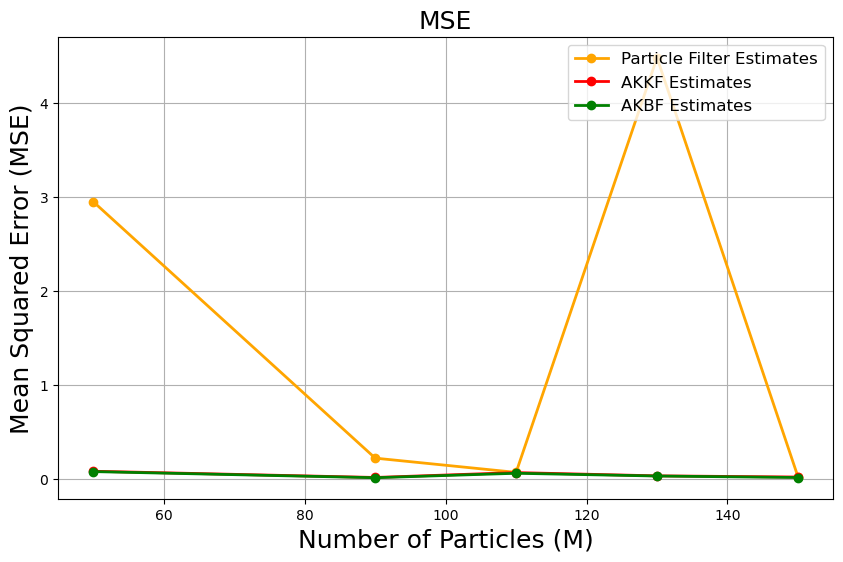

In [343]:
import numpy as np
import matplotlib.pyplot as plt

init_state = np.array([1.0, 1.0, 1.0])
t = 0
h = 0.01  # 步长


P_init = {
    'mean': [1.0, 1.0, 1.0],  # 三维初始均值
    'cov':1 * np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ])  # 三维协方差矩阵
}


N = 100
sigma_u = 0
sigma_v = 1

# 定义粒子数量列表
M_values = [100, 150, 200, 250]

# 生成真实状态
true_states = generate_true_states(init_state, t, h, N, func = lorenz63, sigma=10.0, rho=28.0, beta=8.0/3.0)
# 存储每个M对应的均方误差
pf_mse_list = []
akbf_mse_list = []
akkf_mse_list = []

# 运行滤波器并计算MSE
for M in M_values:
    u_n = np.random.normal(0, (sigma_u), M)
    v_n = np.random.normal(0, (sigma_v), M)
    pf_estimates = particle_filter(P_init, M, N, sigma_u, sigma_v)
    mse = np.mean((pf_estimates - true_states)**2)
    pf_mse_list.append(mse)
    
    _, _, akkf_estimates = adaptive_kernel_kalman_filter(P_init, M, N, u_n, v_n, sigma_v)
    akkf_estimates_flat = np.array([estimate.squeeze() for estimate in akkf_estimates])
    mse = np.mean((akkf_estimates_flat - true_states)**2)
    akkf_mse_list.append(mse)
    
    _, akbf_estimates = adaptive_kernel_byes_filter(P_init, M, N, u_n, v_n)
    akbf_estimates_flat = np.array([estimate.squeeze() for estimate in akbf_estimates])
    mse = np.mean((akbf_estimates_flat - true_states)**2)
    akbf_mse_list.append(mse)

# 绘制MSE vs 粒子数量的图像

fig = plt.figure(figsize=(10, 6))
plt.plot(M_values, pf_mse_list, label='Particle Filter Estimates', marker='o', linestyle='-', color='orange', linewidth=2)
plt.plot(M_values, akkf_mse_list, label='AKKF Estimates', marker='o', linestyle='-', color='red', linewidth=2)
plt.plot(M_values, akbf_mse_list, label='AKBF Estimates', marker='o', linestyle='-', color='green', linewidth=2)
plt.title('MSE', fontsize=18)
plt.xlabel('Number of Particles (M)', fontsize=18)
plt.ylabel('Mean Squared Error (MSE)', fontsize=18)
plt.grid(True)
plt.legend(loc='upper right', fontsize=12)
plt.show()

with open('Q-lorenz63-sigma4-copy-2.pkl', 'wb') as f:
    pickle.dump(fig, f)
    
    

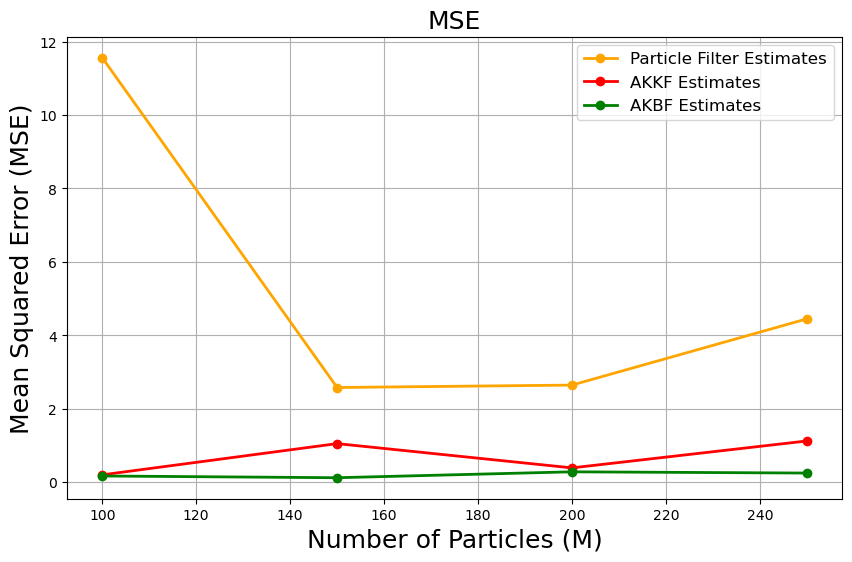

In [476]:
import numpy as np
import matplotlib.pyplot as plt

init_state = np.array([1.0, 1.0, 1.0])
t = 0
h = 0.01  # 步长


P_init = {
    'mean': [1.0, 1.0, 1.0],  # 三维初始均值
    'cov':4 * np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ])  # 三维协方差矩阵
}


N = 100
sigma_u = 0
sigma_v = 4

# 定义粒子数量列表
M_values = [100, 150, 200, 250]

# 生成真实状态
true_states = generate_true_states(init_state, t, h, N, func = lorenz63, sigma=10.0, rho=28.0, beta=8.0/3.0)
# 存储每个M对应的均方误差
pf_mse_list = []
akbf_mse_list = []
akkf_mse_list = []

# 运行滤波器并计算MSE
for M in M_values:
    u_n = np.random.normal(0, (sigma_u), M)
    v_n = np.random.normal(0, (sigma_v), M)
    pf_estimates = particle_filter(P_init, M, N, sigma_u, sigma_v)
    mse = np.mean((pf_estimates - true_states)**2)
    pf_mse_list.append(mse)
    
    _, _, akkf_estimates = adaptive_kernel_kalman_filter(P_init, M, N, u_n, v_n, sigma_v)
    akkf_estimates_flat = np.array([estimate.squeeze() for estimate in akkf_estimates])
    mse = np.mean((akkf_estimates_flat - true_states)**2)
    akkf_mse_list.append(mse)
    
    _, akbf_estimates = adaptive_kernel_byes_filter(P_init, M, N, u_n, v_n)
    akbf_estimates_flat = np.array([estimate.squeeze() for estimate in akbf_estimates])
    mse = np.mean((akbf_estimates_flat - true_states)**2)
    akbf_mse_list.append(mse)

# 绘制MSE vs 粒子数量的图像

fig = plt.figure(figsize=(10, 6))
plt.plot(M_values, pf_mse_list, label='Particle Filter Estimates', marker='o', linestyle='-', color='orange', linewidth=2)
plt.plot(M_values, akkf_mse_list, label='AKKF Estimates', marker='o', linestyle='-', color='red', linewidth=2)
plt.plot(M_values, akbf_mse_list, label='AKBF Estimates', marker='o', linestyle='-', color='green', linewidth=2)
plt.title('MSE', fontsize=18)
plt.xlabel('Number of Particles (M)', fontsize=18)
plt.ylabel('Mean Squared Error (MSE)', fontsize=18)
plt.grid(True)
plt.legend(loc='upper right', fontsize=12)
plt.show()

with open('Q-lorenz63-sigma4-copy-2.pkl', 'wb') as f:
    pickle.dump(fig, f)
    
    
    

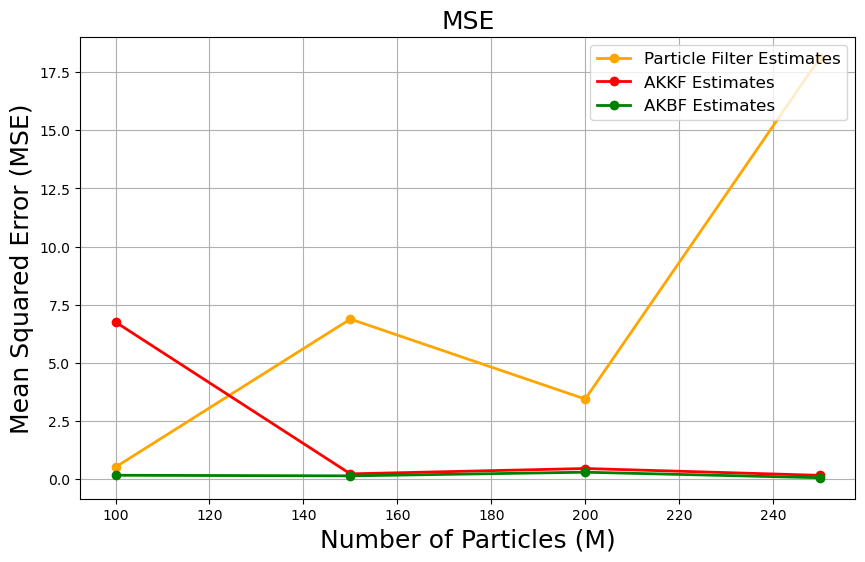

In [489]:
import numpy as np
import matplotlib.pyplot as plt

init_state = np.array([1.0, 1.0, 1.0])
t = 0
h = 0.01  # 步长


P_init = {
    'mean': [1.0, 1.0, 1.0],  # 三维初始均值
    'cov':4 * np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ])  # 三维协方差矩阵
}


N = 100
sigma_u = 0
sigma_v = 4

# 定义粒子数量列表
M_values = [100, 150, 200, 250]

# 生成真实状态
true_states = generate_true_states(init_state, t, h, N, func = lorenz63, sigma=10.0, rho=28.0, beta=8.0/3.0)
# 存储每个M对应的均方误差
pf_mse_list = []
akbf_mse_list = []
akkf_mse_list = []

# 运行滤波器并计算MSE
for M in M_values:
    u_n = np.random.normal(0, (sigma_u), M)
    v_n = np.random.normal(0, (sigma_v), M)
    pf_estimates = particle_filter(P_init, M, N, sigma_u, sigma_v)
    mse = np.mean((pf_estimates - true_states)**2)
    pf_mse_list.append(mse)
    
    _, _, akkf_estimates = adaptive_kernel_kalman_filter(P_init, M, N, u_n, v_n, sigma_v)
    akkf_estimates_flat = np.array([estimate.squeeze() for estimate in akkf_estimates])
    mse = np.mean((akkf_estimates_flat - true_states)**2)
    akkf_mse_list.append(mse)
    
    _, akbf_estimates = adaptive_kernel_byes_filter(P_init, M, N, u_n, v_n)
    akbf_estimates_flat = np.array([estimate.squeeze() for estimate in akbf_estimates])
    mse = np.mean((akbf_estimates_flat - true_states)**2)
    akbf_mse_list.append(mse)

# 绘制MSE vs 粒子数量的图像

fig = plt.figure(figsize=(10, 6))
plt.plot(M_values, pf_mse_list, label='Particle Filter Estimates', marker='o', linestyle='-', color='orange', linewidth=2)
plt.plot(M_values, akkf_mse_list, label='AKKF Estimates', marker='o', linestyle='-', color='red', linewidth=2)
plt.plot(M_values, akbf_mse_list, label='AKBF Estimates', marker='o', linestyle='-', color='green', linewidth=2)
plt.title('MSE', fontsize=18)
plt.xlabel('Number of Particles (M)', fontsize=18)
plt.ylabel('Mean Squared Error (MSE)', fontsize=18)
plt.grid(True)
plt.legend(loc='upper right', fontsize=12)
plt.show()

with open('Q-lorenz63-sigma4-copy-2.pkl', 'wb') as f:
    pickle.dump(fig, f)
    
    
    